[[_TOC_]]

Puzzle
--

https://thefiddler.substack.com/p/can-you-squeeze-the-squares

**This Week’s Fiddler**

There’s a square board with side length A. Your friend cleverly places a unit square on the board and challenges you to place another unit square on the board—without moving the first one—so that it too is entirely on the board and the squares don’t overlap. (The unit squares can touch each other.)

Alas, it’s impossible for you to do so! But there’s some minimum value of A for which you can always place a second unit square on the board, no matter how cleverly your friend places the first one.

What is this minimum value of A?

**This Week’s Extra Credit**

Now there’s another square board with side length B. This time, your friend cleverly places three unit squares (which can touch but not overlap) and issues a similar challenge, asking you to place one more unit square on the board.

Once again, it’s impossible for you to do so! But there’s some minimum value of B for which you can always place a fourth unit square on the board, no matter how cleverly your friend places the first three squares.

What is this minimum value of B?

Fiddler Solution
---

By symmetry, the blocking piece should be placed in the center of the board. If it is placed or tilted to one side, it will allow a piece to be placed on the other side.

There are 2 symmetric options. 

1. *Centered and parallel to the sides of the board*. This yields $A = 3$.

2. *Centered and diagonal to the sides of the board* This yields $A = 2 + 1/\sqrt{2} = 2.707$

So $A = 3$.

| -- | -- | -- |
| -- | -- | -- |
| -- | X  | -- |
| -- | -- | -- |

Extra Credit Solution
---

Let's start with some observations.

B must be greater than 3 because a board of size 3 is blocked by a single tile (Fiddler case). 

When we go from 3 to 4, we get another 7 unit squares added to the board. I can see how to use the extra 2 pieces to block 3 more each, but that still leaves space for another unit square. So, B is likely to be less than 4, unless I missed something clever.

Considering further simple cases like 5 and 6, it gets increasingly hard to conceive of how 3 tiles could block such larger boards.

So, B is quite likely to be between 3 and 4, with a small chance of being between 4 and 5. This helps limit our search space.

I also think that the optimal blocking arrangement is likely to have an axis of symmetry, but I am not as certain. Anyway, there are 2 possible axes of symmetry (parallel to the sides, or along a diagonal). So, we could definitely make sure to search such arrangements particularly carefully.

---

I am going to try to use shapely to actually search configurations to pin down B more closely.

True
10.25
[(0.0, 0.0), (3.5, 0.0), (3.5, 3.5), (0.0, 3.5), (0.0, 0.0)]
2


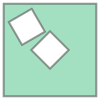

In [2]:
import shapely

def create_square_on_board(board_side, frac_x, frac_y, theta, square_side=1.0):
    from shapely.geometry import Polygon
    from shapely.affinity import rotate
    aligned_sq = Polygon([ 
            (frac_x * board_side - square_side/2, frac_y * board_side - square_side/2),
            (frac_x * board_side + square_side/2, frac_y * board_side - square_side/2),
            (frac_x * board_side + square_side/2, frac_y * board_side + square_side/2),
            (frac_x * board_side - square_side/2, frac_y * board_side + square_side/2)
        ])
    rotated_sq = rotate(aligned_sq, theta, origin=(frac_x * board_side, frac_y * board_side))
    return rotated_sq

def create_board_with_holes(board_side, hole_pattern):
    """
    Create a square board with specified side length and square holes.
    parameters:
    side (float): Length of the sides of the board.
    hole_pattern (list of tuples): Each tuple contains (frac_x, frac_Y, theta(in degrees))
    """   
    from shapely.geometry import Polygon

    # Create holes based on the provided pattern
    # Each hole is defined by its center (frac_x, frac_y) and rotation angle theta
    hole_coords = []
    for pattern in hole_pattern:
        frac_x, frac_y, theta = pattern        
        rotated_hole = create_square_on_board(board_side, frac_x, frac_y, theta)
        rotated_coords = list(rotated_hole.exterior.coords)
        hole_coords.append(rotated_coords)

    # Create the main square board
    board_coords = [(0, 0), (board_side, 0), (board_side, board_side), (0, board_side)]
    board = Polygon(board_coords, holes=hole_coords)

    return board

X = create_board_with_holes(3.5, [(0.5, 0.5, 45), (0.25, 0.75, 30)])
#print(X)
print(X.is_valid)
print(X.area)
print(X.exterior.coords[:])
print(len(X.interiors))
X


UPDATE: I have a guess that B is going to turn out to be $2 + \sqrt{2} = 3.414$. I'll use that in case I can't finish the code below.

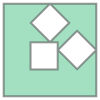

In [3]:
create_board_with_holes(3.415, [(1.49/3.414, 1.49/3.414, 0), (2.707/3.414, 0.5, 45), (0.5, 2.707/3.414, 45)])

In [4]:
#create_board_with_holes(3.415, [(1.49/3.414, 1.49/3.414, 0), (2.707/3.414, 0.5, 45), (0.5, 2.707/3.414, 45), ((1-0.5/3.414), (1-0.5/3.414), 0)])

Here there's just enough room to insert a square on 4 corners, but there's no room in the center, so maybe this is not optimal.

But even if I move the lower left square, expanding the board is not possible because the 2 diagonal squares can't really block any more. There are 3 corners still open. So, maybe this is optimal after all??

Or maybe you can shift the top one left, the right one upward, and then slant the other one to block out other stuff and make the board slightly larger ???

In [5]:
def square_fits_on_board(board, frac_x, frac_y, theta, square_side=1.0):
    """
    Check if a square can be added to the board at the specified position and rotation.
    """
    sq = create_square_on_board(board.bounds[2] - board.bounds[0], frac_x, frac_y, theta, square_side)
    return board.contains(sq)

def board_has_space_for_square(board, num_tries=1000, square_side=1.0):
    """
    Check if a square can be added to the board without overlapping existing holes.
    """
    import random
    for i in range(num_tries):
        frac_x = random.uniform(0.12, 0.88)
        frac_y = random.uniform(0.12, 0.88)
        theta = random.uniform(0, 90)
        if square_fits_on_board(board, frac_x, frac_y, theta, square_side):
            return True
    return False # No space found after num_tries attempts

def find_minimum_board_size(hole_pattern, square_side=1.0):
    """
    Find the minimum board size that can accommodate the holes defined by hole_pattern.
    """
    for i in range(1, 200):
        board_side = 3.3 + i * 0.01
        board = create_board_with_holes(board_side, hole_pattern)
        if not board.is_valid:
            return None, None  
            # Invalid board configuration - return right away
        if board_has_space_for_square(board, square_side=square_side):
            return board_side, board
    return None, None  # No suitable board size found

def find_good_hole_patterns(num_patterns=1000, square_side=1.0):
    import random
    good_results = []
    num_invalid_results = 0
    for i in range(num_patterns):
        hole_pattern = [(random.uniform(0.12, 0.88), random.uniform(0.12, .88), random.uniform(0, 90)) for _ in range(3)]
        board_side, board = find_minimum_board_size(hole_pattern, square_side=square_side) 
        if board_side is not None:
            good_results.append((board_side, board, hole_pattern))
        else:
            num_invalid_results += 1
    print(f"Found {len(good_results)} good hole patterns out of {num_patterns} attempts.")
    print(f"Number of invalid results: {num_invalid_results}")
    good_results.sort(key=lambda x: x[0], reverse=True)  # Sort by board size
    for size, board, pattern in good_results[:20]:  # Display top 20 results
        print(f"Board Size: {size:.4f}, Area: {board.area:.4f}")
    return good_results[0][1] if good_results else None

Found 14 good hole patterns out of 1000 attempts.
Number of invalid results: 986
Board Size: 3.3500, Area: 8.2225
Board Size: 3.3100, Area: 7.9561
Board Size: 3.3100, Area: 7.9561
Board Size: 3.3100, Area: 7.9561
Board Size: 3.3100, Area: 7.9561
Board Size: 3.3100, Area: 7.9561
Board Size: 3.3100, Area: 7.9561
Board Size: 3.3100, Area: 7.9561
Board Size: 3.3100, Area: 7.9561
Board Size: 3.3100, Area: 7.9561
Board Size: 3.3100, Area: 7.9561
Board Size: 3.3100, Area: 7.9561
Board Size: 3.3100, Area: 7.9561
Board Size: 3.3100, Area: 7.9561


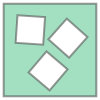

In [6]:
find_good_hole_patterns(1000, square_side=1.0)

These results are not convincing at all. Need better code.

Conclusion
---

Didn't really have enough time and ideas to make the coding approach work.

But I do think the answer is 3.414, with one arrangement being something like this.

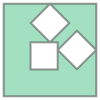

In [23]:
create_board_with_holes(3.414, [
    (1.49/3.414, 1.49/3.414, 0), 
    (2.7/3.414, 0.5, 45), 
    (0.5, 2.7/3.414, 45), 
    ])

And here it is with some corner squares added to show where unit squares could be squeezed in as the board grows larger.

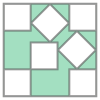

In [24]:
create_board_with_holes(3.45, [
    (1.49/3.414, 1.49/3.414, 0), 
    (2.7/3.414, 0.5, 45), 
    (0.5, 2.7/3.414, 45), 
    (1-0.5/3.414, 1-0.5/3.414, 0), 
    (0.5/3.414, 1-0.5/3.414, 0),
    (1-0.5/3.414, 0.5/3.414, 0),
    (0.5/3.414, 0.5/3.414, 0),
    ])

Solution
----
https://thefiddler.substack.com/p/can-you-canoodle-at-the-coldplay